In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Generate synthetic stock price data for illustration purposes
# Replace this with your actual data loading and preprocessing
np.random.seed(42)
data = np.random.randint(50, 150, size=1000) + np.cumsum(np.random.normal(0, 1, size=1000))
df = pd.DataFrame(data, columns=['Closing_Price'])
df

,Closing_Price
0,102.523124
1,144.062034
2,65.024788
3,121.834449
4,109.958831
...,...
995,117.670048
996,174.118190
997,127.676389
998,209.112141


Epoch 1/100
396/396 [==============================] - 10s 9ms/step - loss: 0.0535 - val_loss: 0.0525
Epoch 2/100
396/396 [==============================] - 3s 7ms/step - loss: 0.0363 - val_loss: 0.0347
Epoch 3/100
396/396 [==============================] - 3s 7ms/step - loss: 0.0349 - val_loss: 0.0330
Epoch 4/100
396/396 [==============================] - 3s 8ms/step - loss: 0.0346 - val_loss: 0.0305
Epoch 5/100
396/396 [==============================] - 3s 8ms/step - loss: 0.0337 - val_loss: 0.0300
Epoch 6/100
396/396 [==============================] - 3s 8ms/step - loss: 0.0330 - val_loss: 0.0347
Epoch 7/100
396/396 [==============================] - 3s 7ms/step - loss: 0.0329 - val_loss: 0.0311
Epoch 8/100
396/396 [==============================] - 3s 7ms/step - loss: 0.0325 - val_loss: 0.0312
Epoch 9/100
396/396 [==============================] - 3s 7ms/step - loss: 0.0319 - val_loss: 0.0319
Epoch 10/100
396/396 [==============================] - 3s 8ms/step - loss: 0.0323 - val_l

99/99 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 77/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 78/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 79/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 80/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 81/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 82/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 83/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 84/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 85/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 86/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 87/100
99/99 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 88/100
99/99 [=====================

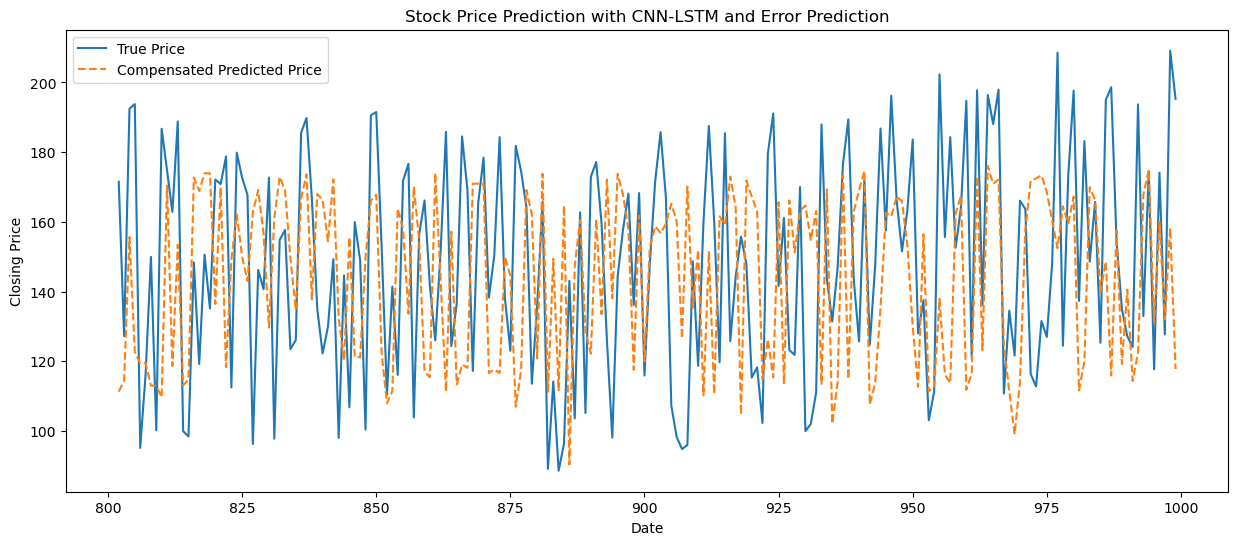

In [16]:

# Data preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Closing_Price']])

# Create sequences for the CNN-LSTM model
sequence_length = 10  # Adjust as needed
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i : i + sequence_length])
    y.append(df_scaled[i + sequence_length, 0])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))         
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Adjust the loss function as needed

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)

# Error prediction model
error_model = Sequential()
error_model.add(Dense(1000, input_dim=1, activation='relu'))
error_model.add(Dense(100, activation='relu'))
error_model.add(Dense(100, activation='relu'))
error_model.add(Dense(100, activation='relu'))
error_model.add(Dense(100, activation='relu'))
error_model.add(Dense(1))

# Compile the error prediction model
error_model.compile(optimizer='adam', loss='mse')  # Adjust the loss function as needed

# Train the error prediction model on the absolute errors
absolute_errors = np.abs(y_test - predictions.flatten())
error_model.fit(predictions, absolute_errors, epochs=100, batch_size=2)

# Use the error prediction model to adjust predictions
error_predictions = error_model.predict(predictions)
compensated_predictions = predictions + error_predictions

# Inverse transform the predictions for plotting
compensated_predictions = scaler.inverse_transform(np.hstack((compensated_predictions, np.zeros_like(compensated_predictions))))[:, 0]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df.index[-len(compensated_predictions):], df['Closing_Price'].values[-len(compensated_predictions):], label='True Price')
plt.plot(df.index[-len(compensated_predictions):], compensated_predictions, label='Compensated Predicted Price', linestyle='dashed')
plt.title('Stock Price Prediction with CNN-LSTM and Error Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [17]:
compensated_predictions

array([111.257416, 114.47649 , 155.6324  , 122.609474, 119.40472 ,
       119.449   , 113.01188 , 112.98254 , 109.630554, 170.4003  ,
       118.66539 , 153.42169 , 113.12559 , 114.678665, 172.70125 ,
       168.8677  , 173.94472 , 173.9247  , 136.42625 , 169.83986 ,
       118.27485 , 149.2656  , 162.1254  , 149.9884  , 143.02547 ,
       162.74377 , 169.15323 , 156.49052 , 129.63515 , 161.16104 ,
       172.88554 , 169.08298 , 149.5736  , 134.7008  , 166.75388 ,
       173.63283 , 137.76657 , 167.98175 , 166.32271 , 154.37947 ,
       172.18915 , 132.20087 , 120.2692  , 155.5335  , 121.14623 ,
       121.14892 , 149.67189 , 166.08783 , 167.78162 , 122.46636 ,
       107.90769 , 111.38938 , 163.82686 , 157.95207 , 133.62325 ,
       170.09386 , 154.63177 , 116.98007 , 115.45111 , 173.98378 ,
       143.32256 , 111.33624 , 157.15295 , 113.32333 , 119.04226 ,
       118.11102 , 170.91978 , 170.97539 , 170.941   , 116.606155,
       117.598366, 116.62112 , 149.85165 , 144.48146 , 106.929

In [18]:
df['Closing_Price'].values[-len(compensated_predictions):]

array([171.48247369, 127.19219914, 192.45959146, 193.78128926,
        95.11319881, 116.10524116, 149.9302814 , 100.17453624,
       186.71104608, 174.8125781 , 162.84075926, 188.83164026,
        99.91753583,  98.39223406, 148.3672071 , 119.1849734 ,
       150.57518095, 135.13299126, 172.14334388, 170.83150765,
       178.76639398, 112.46116928, 179.85165708, 172.66468577,
       167.7213357 ,  96.25102845, 146.18052967, 140.66703132,
       172.73150573,  97.75603917, 154.81670377, 157.67261622,
       123.46292147, 126.0628502 , 185.59360104, 189.81236289,
       166.59892002, 135.08964615, 122.23831361, 129.90122764,
       149.28782498,  97.98535529, 144.59717847, 106.76759469,
       159.92816867, 148.9312147 , 100.36815286, 190.55879914,
       191.50835328, 153.02345531, 110.46953417, 141.40385408,
       116.03697538, 171.81220998, 176.64209696, 103.84011652,
       156.38157925, 166.14073441, 141.56422401, 125.97318171,
       151.42693727, 185.81874127, 124.3398297 , 136.52